### Ghirardo Edoardo (3185254), Francois Hoche (3175552), Elisa Tofanelli (3219113)

30561 STOCHASTIC PROCESSES AND SIMULATION IN NATURAL SCIENCES - Group Project

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider
import pickle


# Lotka-Volterra Models: Deterministic vs Stochastic Approaches

In this notebook, we compare three implementations of the classic Lotka-Volterra predator-prey model:

1. **Deterministic model**: this is the standard model using ordinary differential equations (ODEs)
2. **Stochastic differential equation (SDE)**: noise is added to the deterministic model
3. **Stochastic Simulation Algorithm (SSA)**: continuous-time Markkov chain model, with discrete state spaces

In all three cases, the aim is to simulate the dynamics of a predator-prey system, where:
- The prey population grows exponentially in the absence of predators, it declines due to predation at a rate proportional to the predator and prey populations
- The predator population grows at a rate proportional to the prey population, and declines due to natural death at a constant rate

# 1. Deterministic Lotka-Volterra Model 

## Model Equations

Lotka-Volterra equations:
$$
\begin{aligned}
dx = (\alpha x - \beta xy) dt\\
dy = (\delta xy - \gamma y) dt
\end{aligned}
$$


Where:

- $ x $ is the number of prey  
- $ y $ is the number of predators  
- $ \alpha$ is the growth rate of prey in the absence of predators
- $ \beta$ is the rate of predation
- $ \delta$ is the growth rate of predators per prey eaten
- $ \gamma$ is the natural death rate of predators

We will simulate this model using Euler's method, for simplicity and direct comparison with the Euler-Maruyama method we will use in the SDE model.

In [ ]:
def simulate_lv(alpha, beta, delta, gamma, x0, y0, T, dt):
    t = np.arange(0, T, dt) # time vector
    x = [x0]
    y = [y0] # initial populations of prey and predators

    for i in range(1, len(t)):
        dx = alpha * x[i-1] - beta * x[i-1] * y[i-1] # Prey growth
        dy = delta * x[i-1] * y[i-1] - gamma * y[i-1] # Predator growth
        
        x_next = x[i-1] + dx * dt  # solving the ODE using Euler's method 
        y_next = y[i-1] + dy * dt
        
        x.append(max(x_next, 0))
        y.append(max(y_next, 0))
    
    return np.array(t), np.array(x), np.array(y) 

def plot_lv_dynamics(t, x, y): 
    plt.figure(figsize=(12, 4))
    plt.plot(t, x, label='Prey (x)', color='blue')
    plt.plot(t, y, label='Predator (y)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Deterministic Lotka-Volterra Dynamics')
    plt.legend()
    plt.grid(True)
    plt.show()


# since we want to use the interact function, we define the run function for simulation and plot 
def run_lv(alpha, beta, delta, gamma, x0, y0, T, dt):
    t, x, y = simulate_lv(alpha, beta, delta, gamma, x0, y0, T, dt)
    plot_lv_dynamics(t, x, y)

# here is an interactive plot for everything, we can study the behaviour of the model by changing the parameters 
# we can also change the population size, which can be usefull to study the behaviour based on it, because in the futur we will like to have it fixed. 
output_lv = interact(
    run_lv,
    alpha=FloatSlider(min=0.0, max=2.0, step=0.05, value=1.0, description='α (Prey growth)'),
    beta=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='β (Predation rate)'),
    delta=FloatSlider(min=0.005, max=0.1, step=0.005, value=0.075, description='δ (Pred. reproduction)'),
    gamma=FloatSlider(min=0.1, max=2.0, step=0.05, value=1.5, description='γ (Pred. death)'),
    x0=IntSlider(min=10, max=200, step=10, value=40, description='Initial Prey'),
    y0=IntSlider(min=5, max=100, step=5, value=10, description='Initial Predator'),
    T=IntSlider(min=10, max=100, step=5, value=50, description='(Simulation Time)'),
    dt=FloatSlider(min=0.0005, max=0.01, step=0.0005, value=0.01, description='(Timestep)')
)

display(output_lv)

interactive(children=(FloatSlider(value=1.0, description='α (Prey growth)', max=2.0, step=0.05), FloatSlider(v…

<function __main__.run_lv(alpha, beta, delta, gamma, x0, y0, T, dt)>

The default plot is with some significative parameters, but it is possible to change them with the sliders.

# 2. Stochastic Lotka-Volterra Model (continuous case)

This method introduces continuous noise into the ODEs. It captures environmental randomness.


To account for such randomness, we introduce **stochasticity** into the model using **stochastic differential equations (SDEs)**. This leads to the **stochastic Lotka–Volterra (SLV) model**, which captures more realistic population dynamics under uncertain biological conditions.

## Mathematical Formulation

The stochastic model can be written as:

$$
\begin{aligned}
dx &= [\alpha x - \beta xy]\,dt + \sigma_1 x\,dB_1 \\
dy &= [\delta xy - \gamma y]\,dt + \sigma_2 y\,dB_2
\end{aligned}
$$

Where : 

- $ x $ and $ y $ are the number of prey and predators respectively, like in the deterministic model.
- $\alpha, \beta , \gamma , \delta$ are the same as the deterministic model. 
- $ \sigma_1, \sigma_2 $ are the intensities of environmental noise for prey and predators respectively.
- $ dB_1, dB_2$ are independent brownian increments

This model provides a more realistic depiction of population dynamics, allowing us to study phenomena such as extinction risk, persistence under noise, and long-term variability.

We will simulate this model using the Euler-Maruyama method.

In [50]:
def simulate_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt, seed=None):
    if seed is not None:
        np.random.seed(seed)

    t = np.arange(0, T, dt)
    x = np.zeros(len(t))
    y = np.zeros(len(t))
    x[0], y[0] = x0, y0

    for n in range(1, len(t)):
        z_n = np.random.randn()
        w_n = np.random.randn()

        x_prev, y_prev = x[n-1], y[n-1]
        dx = (alpha * x_prev - beta * x_prev * y_prev) * dt + sigma1 * x_prev * np.sqrt(dt) * z_n
        dy = (delta * x_prev * y_prev - gamma * y_prev) * dt + sigma2 * y_prev * np.sqrt(dt) * w_n

        x[n] = max(x_prev + dx, 0)
        y[n] = max(y_prev + dy, 0)

    return t, x, y

# Plotting function
def plot_lv_sde(t, x, y):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(t, x, label='Prey (x)', color='blue')
    plt.plot(t, y, label='Predator (y)', color='red')
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Stochastic Lotka–Volterra Dynamics (Euler–Maruyama)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Wrapper function for interactive simulation
def run_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt):
    t, x, y = simulate_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt, seed=1)
    plot_lv_sde(t, x, y)

# Create interactive UI
output_slv = interact(
    run_lv_sde,
    alpha=FloatSlider(min=0.0, max=2.0, step=0.05, value=1.0, description='α (Prey growth)'),
    beta=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='β (Predation rate)'),
    delta=FloatSlider(min=0.005, max=0.1, step=0.005, value=0.075, description='δ (Pred. reproduction)'),
    gamma=FloatSlider(min=0.1, max=2.0, step=0.05, value=1.5, description='γ (Pred. death)'),
    sigma1=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.2, description='σ₁ (Prey noise)'),
    sigma2=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.2, description='σ₂ (Pred. noise)'),
    x0=IntSlider(min=10, max=200, step=10, value=40, description='Initial Prey'),
    y0=IntSlider(min=5, max=100, step=5, value=10, description='Initial Predator'),
    T=IntSlider(min=10, max=100, step=5, value=50, description='T (Simulation Time)'),
    dt=FloatSlider(min=0.0005, max=0.01, step=0.0005, value=0.01, description='dt (Timestep)')
)

display(output_slv)

interactive(children=(FloatSlider(value=1.0, description='α (Prey growth)', max=2.0, step=0.05), FloatSlider(v…

<function __main__.run_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt)>

The general behavior of the system — governed by the parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ — remains consistent with the deterministic version.

The main difference lies in the presence of stochastic noise: the trajectories are no longer smooth, but exhibit random fluctuations around the deterministic paths. This variability is directly influenced by the noise intensities $\sigma_1$ and $\sigma_2$, which control the amplitude of the stochastic perturbations on the prey and predator populations, respectively.

As expected:
- Lower values of $\sigma_1$ and $\sigma_2$ lead to dynamics that ressembles the deterministic model.
- Higher values introduce more pronounced deviations, increasing the irregularity of the cycles and the unpredictability of population levels.

Overall, the simulation confirms the theoretical expectations: the stochastic model behaves like the deterministic one, but with noise whose magnitude depends directly on the chosen noise parameters.

# 3. Stochastic Lotka-Volterra Model (discrete case)

This approach models discrete birth, death, and interaction events. It's ideal for small populations: unlike the ODE and SDE models, which are continuous in time and space, this model is discrete in the state space (the number of individuals), but continuous in time.

## Mathematical Formulation

We model the predator-prey interactions as a continuous-time Markov chain with discrete state space. The state of the system is represented by the pair $(x,y)$, and the transitions between states are governed by the following reactions:

   $$
   \begin{aligned}
   \text{Prey reproduction:} & \quad x \xrightarrow{\alpha} x + 1 \\
   \text{Predation:} & \quad (x,y) \xrightarrow{\beta} (x -1, y+1) \\
   \text{Predator death:} & \quad y \xrightarrow{\gamma} y -1
   \end{aligned}
   $$

Where:
- $x$ and $y$ are the number of prey and predators respectively, like in the previous models.
- $\alpha$ is the rate of prey reproduction
- $\beta$ is the rate of predation
- $\gamma$ is the rate of predator death

We simulate the model using Gillespie's algorithm.

In [112]:
# Stochastic simulation using Gillespie algorithm
def simulate_lv_reactions(alpha, beta, gamma, x0, y0, T, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Initial time and populations
    t = [0.0]
    x = [x0]
    y = [y0]

    while t[-1] < T and x[-1] > 0 and y[-1] > 0: # Continue while either time is ended, either one of the population is 0
        x_curr, y_curr = x[-1], y[-1]

        # Propensities (event rates)
        a1 = alpha * x_curr                 # Prey reproduction
        a2 = beta * x_curr * y_curr         # Predation
        a3 = gamma * y_curr                 # Predator death
        a_total = a1 + a2 + a3

        if a_total == 0:
            break  # no more reactions possible

        # Time to next event
        dt = np.random.exponential(1.0 / a_total)
        t.append(t[-1] + dt)

        # Determine which event occurs
        r = np.random.rand() * a_total
        if r < a1:
            x.append(x_curr + 1)    # prey reproduces
            y.append(y_curr)
        elif r < a1 + a2:
            x.append(x_curr - 1)    # predation: prey dies
            y.append(y_curr + 1)    # predator reproduces
        else:
            x.append(x_curr)        # predator dies
            y.append(y_curr - 1)
    

    return np.array(t), np.array(x), np.array(y)

def plot_lv_reactions(t, x, y):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.step(t, x, where='post', label='Prey (x)', color='blue')
    plt.step(t, y, where='post', label='Predator (y)', color='red')
    if x[-1] == 0:
        plt.plot(t[-1], x[-1], c='black', marker='X', markersize=20)
    if y[-1] == 0:
        plt.plot(t[-1], y[-1], c='black', marker='X', markersize=20)
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Stochastic Reaction Simulation (Gillespie Algorithm)")
    plt.legend()
    plt.grid(True)

# Create interactive UI for the stochastic simulation
def run_lv_reactions(alpha, beta, gamma, x0, y0, T, seed=1):
    t, x, y = simulate_lv_reactions(alpha, beta, gamma, x0, y0, T, seed=seed)
    plot_lv_reactions(t, x, y)

# Interactive widget with biological parameter descriptions
output_dslv = interact(
    run_lv_reactions,
    alpha=FloatSlider(min=0.00, max=2.0, step=0.1, value=1, description='α (Prey birth)'),
    beta=FloatSlider(min=0.0001, max=0.1, step=0.0005, value=0.01, description='β (Predation)'), 
    gamma=FloatSlider(min=0.01, max=2.0, step=0.01, value=1.5, description='γ (Pred. death)'),
    x0=IntSlider(min=10, max=200, step=10, value=40, description='Initial Prey'),
    y0=IntSlider(min=5, max=100, step=5, value=10, description='Initial Predator'),
    T=IntSlider(min=10, max=100, step=5, value=50, description='T (Simulation Time)')
)

display(output_dslv)

interactive(children=(FloatSlider(value=1.0, description='α (Prey birth)', max=2.0), FloatSlider(value=0.01, d…

<function __main__.run_lv_reactions(alpha, beta, gamma, x0, y0, T, seed=1)>

## Study of the parameters

By playing with the sliders, we notice that some combinations of parameters can lead to the extinction of either species (signalled on the plot with a black cross). We stop the simulation at the time of extinction of either species because in case of prey extinction, we would have almost sure extinction of the predator, while in case of predator extinction, we would have eventual unlimited growth of the prey.

We are interested in studying how the likelihood of extinction varies based on the parameters that we can set. For this reason, we will choose significant default values and intervals of the parameters (which we found interesting in our experiments) and pair them to see how they interactively affect the extinction probability.
- $T$ is fixed at 30
- $x_0$ is fixed at 40
- $y_0$ is fixed at 10
- $\alpha$ will vary between 0.1 and 1.0, with a default value at 0.5
- $\beta$ will vary between 0.01 and 0.05, with a default value at 0.025
- $\gamma$ will vary between 0.1 and 1.0, with a default value at 0.5

In [127]:
def extinction_heatmap(param1_name, param1_vals, param2_name, param2_vals, fixed_params=None, x0=100, y0=20, T=50, runs=50):
    if fixed_params is None:
        fixed_params = {}
    
    # Default parameter values if not specified
    default_params = {
        'alpha': 0.5,  # Default prey birth rate
        'beta': 0.025,  # Default predation rate
        'gamma': 0.5   # Default predator death rate
    }
    
    # Update defaults with any provided fixed parameters
    params = default_params.copy()
    params.update(fixed_params)
    
    # Create empty array for extinction probabilities
    Z = np.zeros((len(param1_vals), len(param2_vals)))
    
    # Loop through parameter combinations
    for i, val1 in enumerate(param1_vals):
        for j, val2 in enumerate(param2_vals):
            # Set the varying parameters
            params[param1_name] = val1
            params[param2_name] = val2
            
            # Run simulations and count extinctions
            ext = 0
            for _ in range(runs):
                _, x, _ = simulate_lv_reactions(
                    alpha=params['alpha'],
                    beta=params['beta'],
                    gamma=params['gamma'],
                    x0=x0, y0=y0, T=T
                )
                if x[-1] == 0:
                    ext += 1
            
            Z[i, j] = ext / runs
    
    return Z

def plot_heatmap(Z, param1_vals, param2_vals, param1_name, param2_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, origin='lower', 
               extent=[param2_vals[0], param2_vals[-1], param1_vals[0], param1_vals[-1]],
               aspect='auto', cmap='plasma')
    
    plt.colorbar(label='Prey Extinction Probability')

    descriptions = {
        'alpha': 'Prey birth rate',
        'beta': 'Predation rate',
        'gamma': 'Predator death rate'
    }
    
    # Format parameter names for axis labels
    param1_label = f"{param1_name} ({descriptions[param1_name]})"
    param2_label = f"{param2_name} ({descriptions[param2_name]})"
    
    plt.ylabel(param1_label)
    plt.xlabel(param2_label)
    plt.title(f'Prey Extinction: {param1_name} vs. {param2_name}')
    plt.grid(False)

alpha_vals = np.linspace(0.1, 1.0, 20)
beta_vals = np.linspace(0.001, 0.05, 20)
gamma_vals = np.linspace(0.1, 1.0, 20)

In [131]:
# code is commented to avoid long runtime
# Z1 = extinction_heatmap('alpha', alpha_vals, 'beta', beta_vals, fixed_params={'gamma': 0.5})
# pickle.dump(Z1, open("Z1.p", "wb"))

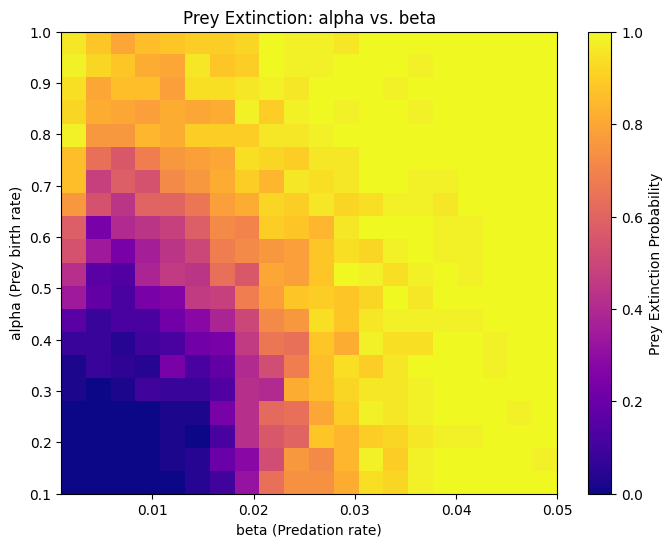

In [ ]:
# load the data from the file
Z1 = pickle.load(open("Z1.p", "rb"))
plot_heatmap(Z1, alpha_vals, beta_vals, 'alpha', 'beta')
plt.show()

The outcome here might seem surprising: higher values of $\alpha$ also lead to a higher extinction rate. This can however be explained by the cycles we see in the interactive plot above. A high prey birth rate leads to higher and faster predator-prey cycles, which increase the likelihood of prey going extinct within the fixed $T$. In this case, we can say that the effect of a higher prey birth rate is similar to that of a longer time. Unsurprisingly, the predation rate $\beta$ seems to have positive correlation with the prey extinction probability.

In [ ]:
# code is commented to avoid long runtime
# Z2 = extinction_heatmap('beta', beta_vals, 'gamma', gamma_vals, fixed_params={'alpha': 0.5})
# pickle.dump(Z2, open("Z2.p", "wb"))

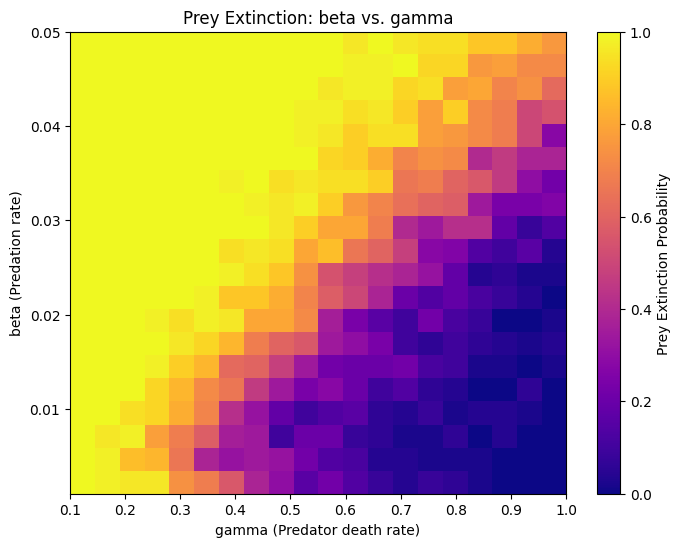

In [129]:
Z2 = pickle.load(open("Z2.p", "rb"))
plot_heatmap(Z2, beta_vals, gamma_vals, 'beta', 'gamma')
plt.show()

In this plot (and in the one below), we see that $\gamma$, the predator death rate, has an unsurprising negative relationship with the prey extinction rate. Once again, higher values of $\beta$ relate with higher extinction rates.

In [ ]:
# code is commented to avoid long runtime
# Z3 = extinction_heatmap('alpha', alpha_vals, 'gamma', gamma_vals, fixed_params={'beta': 0.025})
# pickle.dump(Z3, open("Z3.p", "wb"))

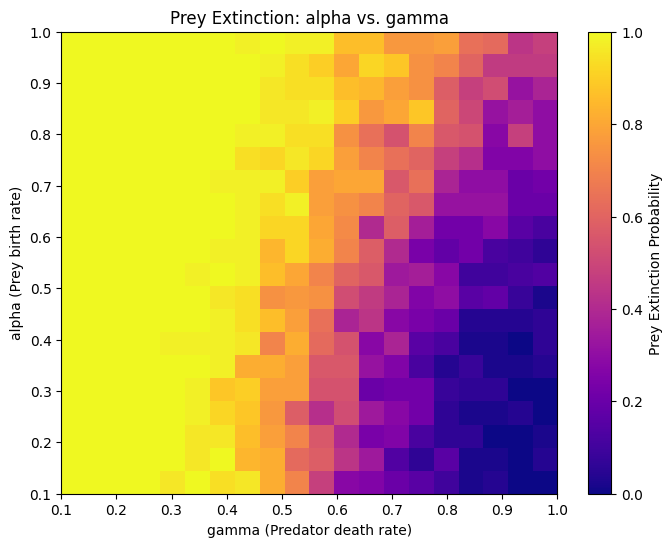

In [132]:
Z3 = pickle.load(open("Z3.p", "rb"))
plot_heatmap(Z3, alpha_vals, gamma_vals, 'alpha', 'gamma')

This plot confirms the effects we have seen previously, suggesting that the three parameters have strong individual contributions to the extinction rate relative to the interaction effects.